Call Price: 10.450583572185565
Put Price : 5.573526022256971
Delta (call): 0.6368306511756191


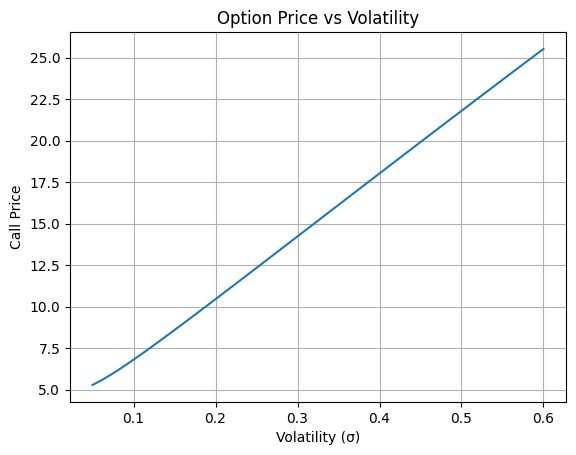

Implied Volatility for market price 12: 0.24111689547354206


In [2]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(r"C:\Users\utkarsh\OneDrive\Desktop\quant-projects\project1_option_vol\src"))
import matplotlib.pyplot as plt
from bs import black_scholes_price, delta, gamma, vega
from implied_vol import implied_volatility

# Parameters  (ample content)
S = 100   # spot price
K = 100   # strike
T = 1.0   # 1 year
r = 0.05  # 5% risk-free rate
sigma = 0.2  # 20% volatility

# --- Pricing & Greeks
call_price = black_scholes_price(S, K, T, r, sigma, "call")
put_price  = black_scholes_price(S, K, T, r, sigma, "put")

print("Call Price:", call_price)
print("Put Price :", put_price)
print("Delta (call):", delta(S, K, T, r, sigma, "call"))

# --- Visualization
sigmas = np.linspace(0.05, 0.6, 50)
prices = [black_scholes_price(S, K, T, r, s, "call") for s in sigmas]

plt.plot(sigmas, prices)
plt.xlabel("Volatility (σ)")
plt.ylabel("Call Price")
plt.title("Option Price vs Volatility")
plt.grid()
plt.show()

# Implied vol example
market_price = 12.0
iv = implied_volatility(S, K, T, r, market_price, "call")
print("Implied Volatility for market price 12:", iv)


Dropdown(description='Stock:', options=('AAPL', 'NFLX', 'PLTR', 'NVDA', 'META', 'AMZN'), value='AAPL')


Selected: AAPL | Current Price: 238.47

Option data for AAPL (expiry 2025-09-05):
Strike: 237.5, Market Price: 2.5
Implied Volatility: 0.3940
Delta: 0.5849, Gamma: 0.079265, Vega: 4.8663, Theta: -356.7997, Rho: 0.3753

Option data for AAPL (expiry 2025-09-05):
Strike: 237.5, Market Price: 2.5
Implied Volatility: 0.3940
Delta: 0.5849, Gamma: 0.079265, Vega: 4.8663, Theta: -356.7997, Rho: 0.3753


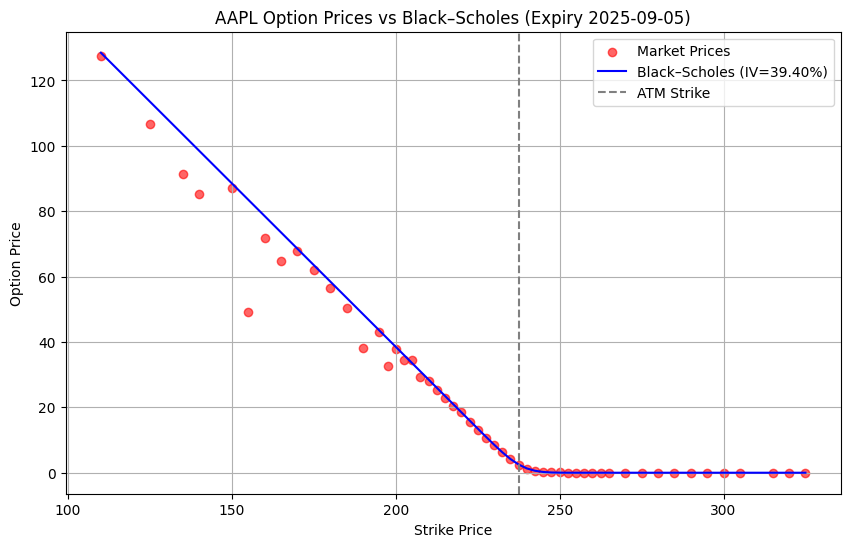

In [5]:
import yfinance as yf
import datetime
from bs import black_scholes_price, delta, gamma, vega, theta, rho
from implied_vol import implied_volatility

import ipywidgets as widgets
from IPython.display import display

# List of stocks
stock_list = ["AAPL", "NFLX", "PLTR", "NVDA", "META", "AMZN"]

# Create dropdown widget
dropdown = widgets.Dropdown(
    options=stock_list,
    description='Stock:',
    value="AAPL"  # default
)

display(dropdown)

# Wrap dropdown value into yf.Ticker
ticker_symbol = dropdown.value
ticker = yf.Ticker(ticker_symbol)

# --- Current stock price
S = ticker.history(period="1d")["Close"].iloc[-1]
print(f"\nSelected: {ticker_symbol} | Current Price: {S:.2f}")

# --- Get option chain (nearest expiry, if available)
if ticker.options:  # indices may not always have options
    expiries = ticker.options
    expiry = expiries[0]   # pick the nearest expiry
    opt_chain = ticker.option_chain(expiry)
    calls = opt_chain.calls

    # --- Pick ATM strike
    atm_row = calls.iloc[(calls['strike'] - S).abs().argsort()[:1]]
    K = atm_row['strike'].values[0]
    market_price = atm_row['lastPrice'].values[0]

    # --- Time to expiry (in years)
    today = datetime.date.today()
    expiry_date = datetime.datetime.strptime(expiry, "%Y-%m-%d").date()
    T = (expiry_date - today).days / 365

    # --- Assume risk-free rate
    r = 0.05

    # --- Implied volatility
    iv = implied_volatility(S, K, T, r, market_price, option_type="call")

    # --- Greeks at implied vol
    d = delta(S, K, T, r, iv, "call")
    g = gamma(S, K, T, r, iv)
    v = vega(S, K, T, r, iv)
    t = theta(S, K, T, r, iv, "call")
    rh = rho(S, K, T, r, iv, "call")

    print(f"\nOption data for {ticker_symbol} (expiry {expiry}):")
    print(f"Strike: {K}, Market Price: {market_price}")
    print(f"Implied Volatility: {iv:.4f}")
    print(f"Delta: {d:.4f}, Gamma: {g:.6f}, Vega: {v:.4f}, Theta: {t:.4f}, Rho: {rh:.4f}")
else:
    print(f"\n{ticker_symbol} has no option chain available on Yahoo Finance.")
import numpy as np
import matplotlib.pyplot as plt

# --- Get full call option chain for the same expiry
calls = opt_chain.calls.copy()

# Extract strikes and market prices
strikes = calls['strike'].values
market_prices = calls['lastPrice'].values

# Compute BS prices at each strike using the same implied volatility
bs_prices = [
    black_scholes_price(S, K_strike, T, r, iv, option_type="call")
    for K_strike in strikes
]

# --- Plot
plt.figure(figsize=(10, 6))
plt.scatter(strikes, market_prices, color="red", label="Market Prices", alpha=0.6)
plt.plot(strikes, bs_prices, color="blue", label=f"Black–Scholes (IV={iv:.2%})")

plt.axvline(K, color="gray", linestyle="--", label="ATM Strike")
plt.title(f"{ticker_symbol} Option Prices vs Black–Scholes (Expiry {expiry})")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.show()


